In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
cad_df = pd.read_csv('final_data.csv')
cad_df['Cath'].value_counts()

,count
Cath,
0,216
1,87


# ***SMOTE-ENC***

In [ ]:
#Separate features and target columns
X_feature = cad_df.drop('Cath', axis=1)
y_target = cad_df['Cath']

categorical_cols = [col for col in X_feature.columns if X_feature[col].nunique() <= 4]
categorical_indices = [X_feature.columns.get_loc(col) for col in categorical_cols]

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=1)
X_balanced, y_balanced = smote_nc.fit_resample(X_feature, y_target)

print("Imbalanced distribution:", Counter(y_target))
print("Balanced distribution:", Counter(y_balanced))

Imbalanced distribution: Counter({0: 216, 1: 87})
Balanced distribution: Counter({0: 216, 1: 216})


In [ ]:
X_balanced

,Age,Weight,Length,Sex,BMI,DM,HTN,Current Smoker,EX-Smoker,FH,...,HB,K,Na,WBC,Lymph,Neut,PLT,EF-TTE,Region RWMA,VHD
0,53,90,175,1,29.387755,0,1,1,0,0,...,15.600000,4.700000,141,5700,39,52,261,50,0,1
1,67,70,157,0,28.398718,0,1,0,0,0,...,13.900000,4.700000,156,7700,38,55,165,40,4,1
2,54,54,164,1,20.077335,0,0,1,0,0,...,13.500000,4.700000,139,7400,38,60,230,40,2,3
3,66,67,158,0,26.838648,0,1,0,0,0,...,12.100000,4.400000,142,13000,18,72,742,55,0,2
4,50,87,153,0,37.165193,0,1,0,0,0,...,13.200000,4.000000,140,9200,55,39,274,50,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,48,81,174,1,26.687577,0,0,0,0,0,...,16.391633,4.021673,140,9944,27,66,206,52,0,1
428,40,79,170,1,27.360253,0,0,0,0,0,...,14.839652,4.291561,139,10658,30,62,252,50,0,1
429,65,69,172,1,23.695870,0,0,0,0,0,...,14.068072,4.428313,142,7164,22,67,187,45,0,1
430,47,76,163,0,28.838911,0,1,0,0,0,...,14.090008,3.987994,144,6239,37,56,206,55,0,3


In [ ]:
X_balanced.shape

(432, 54)

In [ ]:
#60% data for training, 20% data for validation, 20% data for testing
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f"The training set contains {X_train.shape[0]} patient records and {X_train.shape[1]} features.")
print(f"The validation set contains {X_val.shape[0]} patient records with the same {X_val.shape[1]} features.")
print(f"The test set also holds {X_test.shape[0]} patient records, each with {X_test.shape[1]} features.")

The training set contains 259 patient records and 54 features.
The validation set contains 86 patient records with the same 54 features.
The test set also holds 87 patient records, each with 54 features.


# ***Random Forest Classifier (RF)***

In [ ]:
param_random = {'n_estimators': [50, 100, 150],
                'max_depth': [2, 3, 4],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 4, 8],
                'max_features': ['sqrt', 'log2']}

RF_mdl = RandomForestClassifier()
RF_randomcv = RandomizedSearchCV(RF_mdl, param_random, n_iter=20, cv=5)
RF_randomcv.fit(X_train, y_train)
RF_param = RF_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(RF_randomcv.best_score_))
print("Optimal parameters of RF classifier: ", RF_param)

#Training RF model with optimal parameters
RF_best_mdl = RandomForestClassifier(**RF_param)
RF_best_mdl.fit(X_train, y_train)
training_acc = RF_best_mdl.score(X_train, y_train)
print(f"Training phase accuracy of RF classifier: {training_acc:.4f}")

Best cross-validation score: 0.90
Optimal parameters of RF classifier:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4}
Training phase accuracy of RF classifier: 0.9768


*Predicting on the validation and testing data*

In [ ]:
val_pred = RF_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = RF_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        45
           1       0.93      0.90      0.91        41

    accuracy                           0.92        86
   macro avg       0.92      0.92      0.92        86
weighted avg       0.92      0.92      0.92        86

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        42
           1       0.89      0.91      0.90        45

    accuracy                           0.90        87
   macro avg       0.90      0.90      0.90        87
weighted avg       0.90      0.90      0.90        87



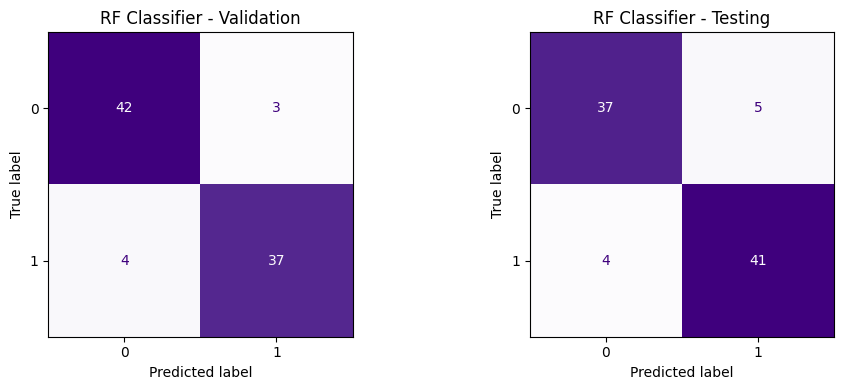

In [ ]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the validation confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('RF Classifier - Validation')

# Plotting the testing confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('RF Classifier - Testing')

plt.tight_layout()
plt.show()

# ***XGBoost (XGB)***

In [ ]:
param_random = {'n_estimators': [50, 80, 100],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.01, 0.02, 0.05],
                'subsample': [0.6, 0.7, 0.8]}

XGB_mdl = XGBClassifier()
XGB_randomcv = RandomizedSearchCV(XGB_mdl, param_random, n_iter=20, cv=5)
XGB_randomcv.fit(X_train, y_train)
XGB_param = XGB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(XGB_randomcv.best_score_))
print("Optimal parameters of XGB classifier: ", XGB_param)

#Training XGB model with optimal parameters
XGB_best_mdl = XGBClassifier(**XGB_param)
XGB_best_mdl.fit(X_train, y_train)
training_acc = XGB_best_mdl.score(X_train, y_train)
print(f"Training phase accuracy of XGB classifier: {training_acc:.4f}")

Best cross-validation score: 0.89
Optimal parameters of XGB classifier:  {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.02}
Training phase accuracy of XGB classifier: 0.9653


In [ ]:
val_pred = XGB_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = XGB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        45
           1       0.93      0.90      0.91        41

    accuracy                           0.92        86
   macro avg       0.92      0.92      0.92        86
weighted avg       0.92      0.92      0.92        86

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.92      0.83      0.88        42
           1       0.86      0.93      0.89        45

    accuracy                           0.89        87
   macro avg       0.89      0.88      0.88        87
weighted avg       0.89      0.89      0.88        87



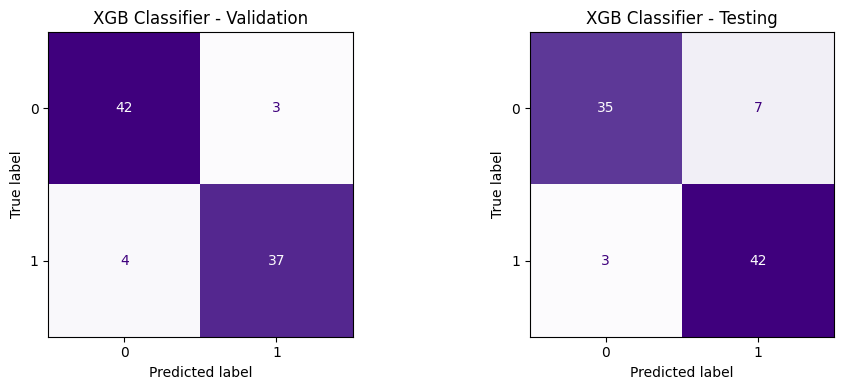

In [ ]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('XGB Classifier - Validation')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('XGB Classifier - Testing')

plt.tight_layout()
plt.show()

# ***Gradient Boosting (GB)***

In [ ]:
param_random = {'n_estimators': [100, 150, 200],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.005, 0.001, 0.015],
                'subsample': [0.6, 0.7, 0.8],
                'min_samples_split': [10, 12],
                'min_samples_leaf': [6, 8, 10]}

GB_mdl = GradientBoostingClassifier()
GB_randomcv = RandomizedSearchCV(GB_mdl, param_random, n_iter=20, cv=5)
GB_randomcv.fit(X_train, y_train)
GB_param = GB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(GB_randomcv.best_score_))
print("Optimal parameters of GB classifier: ", GB_param)

#Training GB model with optimal parameters
GB_best_mdl = GradientBoostingClassifier(**GB_param)
GB_best_mdl.fit(X_train, y_train)
training_acc = GB_best_mdl.score(X_train, y_train)
print(f"Training phase accuracy of GB classifier: {training_acc:.4f}")

Best cross-validation score: 0.89
Optimal parameters of GB classifier:  {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.015}
Training phase accuracy of GB classifier: 0.9807


In [ ]:
val_pred = GB_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = GB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        45
           1       0.93      0.90      0.91        41

    accuracy                           0.92        86
   macro avg       0.92      0.92      0.92        86
weighted avg       0.92      0.92      0.92        86

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        42
           1       0.87      0.91      0.89        45

    accuracy                           0.89        87
   macro avg       0.89      0.88      0.88        87
weighted avg       0.89      0.89      0.88        87



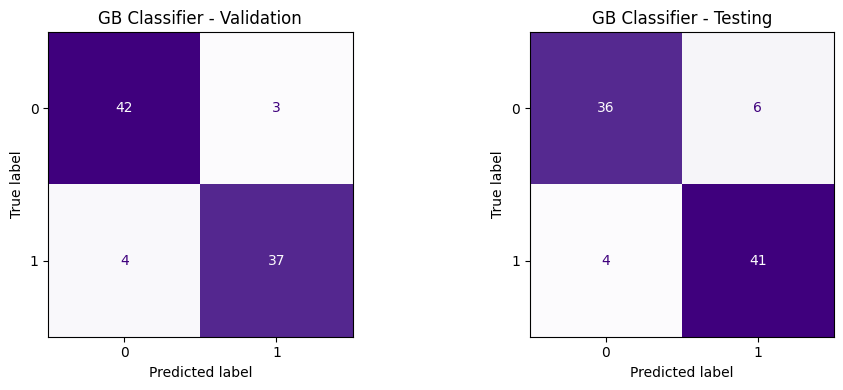

In [ ]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('GB Classifier - Validation')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('GB Classifier - Testing')

plt.tight_layout()
plt.show()